In [35]:
# !pip install scikit-learn
# !pip install seaborn
# !pip install git+https://github.com/neurostatslab/tensortools

# Starting Notebook

Duplicate this notebook and experiment away.  
See [How to Contribute](../Contributing.md) (steps 4 and 5) for help with this.

In this notebook (which is based on the third notebook of the [2022 Cosyne tutorial](https://neural-reckoning.github.io/cosyne-tutorial-2022/)), we're going to use surrogate gradient descent to find a solution to the sound localisation problem. The surrogate gradient descent approach and code is heavily inspired by (certainly not stolen) from [Friedemann Zenke's SPyTorch tutorial](https://github.com/fzenke/spytorch), which I recommend for a deeper dive into the maths.

In [36]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn

dtype = torch.float

# # Check whether a GPU is available
# if torch.backends.mps.is_available():
#     device = torch.device("mps")  # Use Apple's Metal Performance Shaders
# el
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
my_computer_is_slow = True  # set this to True if using Colab

Using device: cpu


## Sound localization stimuli

The following function creates a set of stimuli that can be used for training or testing. We have two ears (0 and 1), and ear 1 will get a version of the signal delayed by an IPD we can write as $\alpha$ in equations (``ipd`` in code). The basic signal is a sine wave as in the previous notebook, made positive, so $(1/2)(1+\sin(\theta)$. In addition, for each ear there will be $N_a$ neurons per ear (``anf_per_ear`` because these are auditory nerve fibres). Each neuron generates Poisson spikes at a certain firing rate, and these Poisson spike trains are independent. In addition, since it is hard to train delays, we seed it with uniformly distributed delays from a minimum of 0 to a maximum of $\pi/2$ in each ear, so that the differences between the two ears can cover the range of possible IPDs ($-\pi/2$ to $\pi/2$). We do this directly by adding a phase delay to each neuron. So for ear $i\in\{0,1\}$ and neuron $j$ at time $t$ the angle $\theta=2\pi f t+i\alpha+j\pi/2N_a$. Finally, we generate Poisson spike trains with a rate $R_\mathrm{max}((1/2)(1+\sin(\theta)))^k$. $R_\mathrm{max}$ (``rate_max``) is the maximum instantaneous firing rate, and $k$ (``envelope_power``) is a constant that sharpens the envelope. The higher $R_\mathrm{max}$ and $k$ the easier the problem (try it out on the cell below to see why).

Here's a picture of the architecture for the stimuli:

![Stimuli architecture](diagrams/arch-stimuli.png)

The functions below return two arrays ``ipd`` and ``spikes``. ``ipd`` is an array of length ``num_samples`` that gives the true IPD, and ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, duration_steps, 2*anf_per_ear)``, where ``duration_steps`` is the number of time steps there are in the stimulus.

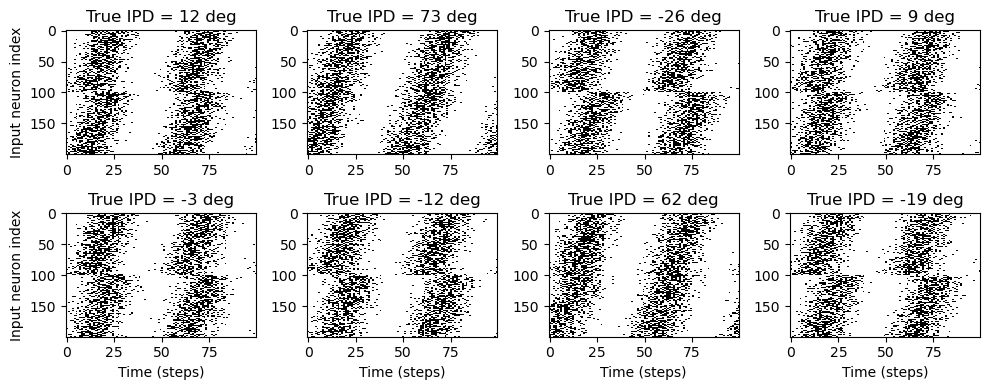

In [37]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1 * ms  # large time step to make simulations run faster for tutorial
anf_per_ear = 100  # repeats of each ear with independent noise
envelope_power = 2  # higher values make sharper envelopes, easier
rate_max = 600 * Hz  # maximum Poisson firing rate
f = 20 * Hz  # stimulus frequency
duration = 0.1 * second  # stimulus duration
# duration = duration / 2
duration_steps = int(np.round(duration / dt))
input_size = 2 * anf_per_ear


# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps) * dt  # array of times
    phi = (
        2 * np.pi * (f * T + np.random.rand())
    )  # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2 * anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi / 2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = (
        phi[np.newaxis, :, np.newaxis] + phase_delays[np.newaxis, np.newaxis, :]
    )
    theta[:, :, anf_per_ear:] = (
        phi[np.newaxis, :, np.newaxis]
        + phase_delays[np.newaxis, np.newaxis, :]
        + ipd[:, np.newaxis, np.newaxis]
    )
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = (
        np.random.rand(num_samples, duration_steps, 2 * anf_per_ear)
        < rate_max * dt * (0.5 * (1 + np.sin(theta))) ** envelope_power
    )
    return spikes


# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = (
        np.random.rand(num_samples) * np.pi - np.pi / 2
    )  # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes


def random_step_ipd_input_signal(num_samples, tensor=True):
    # Generate IPDs linearly spaced from -pi/2 to pi/2
    ipd = np.linspace(-np.pi / 2, np.pi / 2, num_samples)
    # Generate the corresponding spike arrays
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes


# Plot a few just to show how it looks
ipd, spikes = random_ipd_input_signal(8)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        spikes[i, :, :].T, aspect="auto", interpolation="nearest", cmap=plt.cm.gray_r
    )
    plt.title(f"True IPD = {int(ipd[i]*180/np.pi)} deg")
    if i >= 4:
        plt.xlabel("Time (steps)")
    if i % 4 == 0:
        plt.ylabel("Input neuron index")
plt.tight_layout()

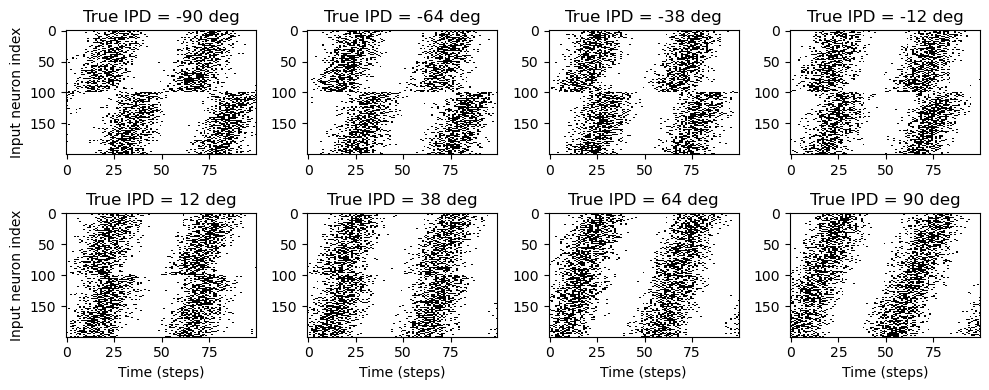

In [38]:
ipd, spikes = random_step_ipd_input_signal(8)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        spikes[i, :, :].T, aspect="auto", interpolation="nearest", cmap=plt.cm.gray_r
    )
    plt.title(f"True IPD = {int(ipd[i]*180/np.pi)} deg")
    if i >= 4:
        plt.xlabel("Time (steps)")
    if i % 4 == 0:
        plt.ylabel("Input neuron index")
plt.tight_layout()

Now the aim is to take these input spikes and infer the IPD. We can do this either by discretising and using a classification approach, or with a regression approach. For the moment, let's try it with a classification approach.

### Training

We train this by dividing the input data into batches and computing gradients across batches. In this notebook, batch and data size is small so that it can be run on a laptop in a couple of minutes, but normally you'd use larger batches and more data. Let's start with the data.

In [39]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size * n_training_batches


# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes, random=True):
    if random:
        perm = torch.randperm(spikes.shape[0])
        spikes = spikes[perm, :, :]
        ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n // batch_size
    for i in range(n_batch):
        x_local = spikes[i * batch_size : (i + 1) * batch_size, :, :]
        y_local = ipds[i * batch_size : (i + 1) * batch_size]
        yield x_local, y_local

## Classification approach

We discretise the IPD range of $[-\pi/2, \pi/2]$ into $N_c$ (``num_classes``) equal width segments. Replace angle $\phi$ with the integer part (floor) of $(\phi+\pi/2)N_c/\pi$. We also convert the arrays into PyTorch tensors for later use. The algorithm will now guess the index $i$ of the segment, converting that to the midpoint of the segment $\phi_i=a+(i+1/2)(b-a)/N_c$ when needed.

The algorithm will work by outputting a length $N_c$ vector $y$ and the index of the maximum value of y will be the guess as to the class (1-hot encoding), i.e. $i_\mathrm{est}=\mathrm{argmax}_i y_i$. We will perform the training with a softmax and negative loss likelihood loss, which is a standard approach in machine learning.

In [40]:
# classes at 15 degree increments
num_classes = 180 // 15
print(f"Number of classes = {num_classes}")


def discretise(ipds):
    return ((ipds + np.pi / 2) * num_classes / np.pi).long()  # assumes input is tensor


def continuise(ipd_indices):  # convert indices back to IPD midpoints
    return (ipd_indices + 0.5) / num_classes * np.pi - np.pi / 2

Number of classes = 12


## Membrane only (no spiking neurons)

Before we get to spiking, we're going to warm up with a non-spiking network that shows some of the features of the full model but without any coincidence detection, it can't do the task. We basically create a neuron model that has everything except spiking, so the membrane potential dynamics are there and it takes spikes as input. The neuron model we'll use is just the LIF model we've already seen. We'll use a time constant $\tau$ of 20 ms, and we pre-calculate a constant $\alpha=\exp(-dt/\tau)$ so that updating the membrane potential $v$ is just multiplying by $\alpha$ (as we saw in the first notebook). We store the input spikes in a vector $s$ of 0s and 1s for each time step, and multiply by the weight matrix $W$ to get the input, i.e. $v\leftarrow \alpha v+Ws$.

We initialise the weight matrix $W$ uniformly with bounds proportionate to the inverse square root of the number of inputs (fairly standard, and works here).

The output of this will be a vector of $N_c$ (``num_classes``) membrane potential traces. We sum these traces over time and use this as the output vector (the largest one will be our prediction of the class and therefore the IPD).

![Membrane only architecture](diagrams/arch-membrane.png)

## Analysis of results

Now we compute the training and test accuracy, and plot histograms and confusion matrices to understand the errors it's making.

This function evaluates the performance of a classifier on given data.

Parameters:
ipds (numpy.ndarray): Inter-pulse intervals data.
spikes (numpy.ndarray): Spike train data.
label (str): Label to be used for the output (e.g., 'Train' or 'Test').
run (function): Classifier function to be evaluated.

The function works by iterating over the data generated by the `data_generator` function. For each batch of data:
- It gets the true labels and discretizes them.
- It runs the classifier on the input data.
- It sums the classifier's output over the time dimension and finds the class with the highest output.
- It calculates the accuracy of the classifier by comparing the predicted classes to the true labels.
- It updates the confusion matrix based on the true and predicted classes.
- It stores the true and estimated labels, and the accuracy for this batch.

After going through all the data, it calculates the overall accuracy and absolute error, and prints them. It also plots two histograms: one for the true labels and one for the estimated labels, and a normalized confusion matrix.

In [41]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true - ipd_est) * 180 / np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=num_classes, label="True")
    plt.hist(ipd_est * 180 / np.pi, bins=num_classes, label="Estimated")
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc="best")
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(
        confusion,
        interpolation="nearest",
        aspect="auto",
        origin="lower",
        extent=(-90, 90, -90, 90),
    )
    plt.xlabel("True IPD")
    plt.ylabel("Estimated IPD")
    plt.title("Confusion matrix")
    plt.tight_layout()

    return 100 * np.mean(accs)


# print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
# run_func = lambda x: membrane_only(x, W)
# analyse(ipds, spikes, 'Train', run=run_func)
# ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
# analyse(ipds_test, spikes_test, 'Test', run=run_func)

This poor performance isn't surprising because this network is not actually doing any coincidence detection, just a weighted sum of input spikes.

## Spiking model

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.

![Full architecture](diagrams/arch-full.png)

### Surrogate gradient descent

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.

In [42]:
beta = 5


class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (input,) = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        # grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = (
            grad_output
            * beta
            * torch.sigmoid(beta * input)
            * (1 - torch.sigmoid(beta * input))
        )
        return grad


spike_fn = SurrGradSpike.apply

### Updated model

The code for the updated model is very similar to the membrane only layer. First, for initialisation we now need two weight matrices, $W_1$ from the input to the hidden layer, and $W_2$ from the hidden layer to the output layer. Second, we run two passes of the loop that you saw above for the membrane only model.

The first pass computes the output spikes of the hidden layer. The second pass computes the output layer and is exactly the same as before except using the spikes from the hidden layer instead of the input layer.

For the first pass, we modify the function in two ways.

Firstly, we compute the spikes with the line ``s = spike_fn(v-1)``. In the forward pass this just computes the Heaviside function of $v-1$, i.e. returns 1 if $v>1$, otherwise 0, which is the spike threshold function for the LIF neuron. In the backwards pass, it returns a gradient of the smoothed version of the Heaviside function.

The other line we change is the membrane potential update line. Now, we multiply by $1-s$ where ($s=1$ if there was a spike in the previous time step, otherwise $s=0$), so that the membrane potential is reset to 0 after a spike (but in a differentiable way rather than just setting it to 0).

In [43]:
num_hidden = 30


# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(
        torch.empty(
            (input_size, num_hidden), device=device, dtype=dtype, requires_grad=True
        )
    )
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(
        torch.empty(
            (num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True
        )
    )
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2


# Run the simulation
def snn(input_spikes, W1, W2, tau=20 * ms):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt / tau)
    for t in range(duration_steps - 1):
        new_v = (alpha * v + h[:, t, :]) * (1 - s)  # multiply by 0 after a spike
        s = spike_fn(v - 1)  # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt / tau)
    for t in range(duration_steps - 1):
        v = alpha * v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded spike trains and membrane potentials
    return s_rec, v_rec

### Training and analysing

We train it as before, except that we modify the functions to take the two weight matrices into account.

Epoch 1: loss=2.46905
Epoch 2: loss=1.58584
Epoch 3: loss=1.23348
Epoch 4: loss=1.04293
Epoch 5: loss=0.93850
Epoch 6: loss=0.85044
Epoch 7: loss=0.78343
Epoch 8: loss=0.73330
Epoch 9: loss=0.70132
Epoch 10: loss=0.65748
Recorded spikes shape:  torch.Size([640, 64, 100, 30])
Recorded input IPDs shape:  torch.Size([640, 64])
Recorded estimated IPDs shape:  torch.Size([640, 64])
Chance accuracy level: 8.3%

Train classifier accuracy: 78.8%
Train absolute error: 4.9 deg

Test classifier accuracy: 47.7%
Test absolute error: 9.7 deg


47.65625

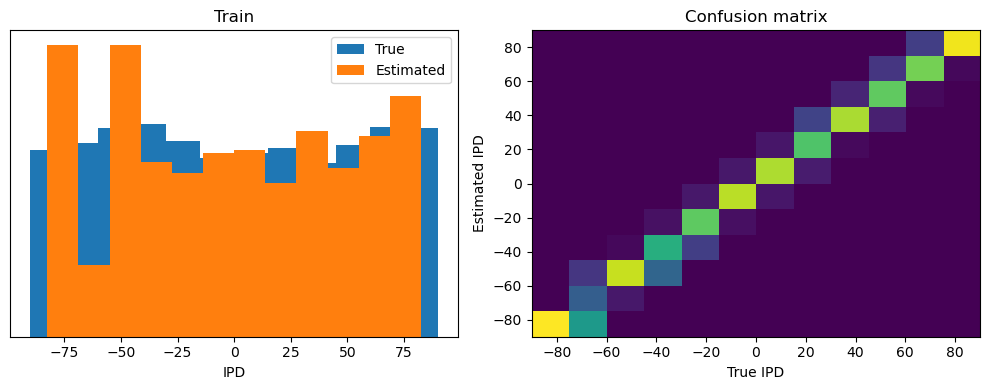

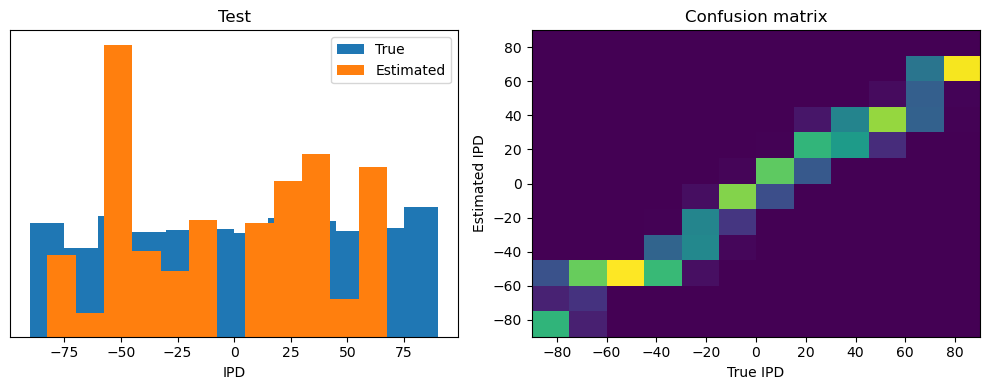

In [44]:
# Training function with spike recording, including network output IPDs
def train_network(ipds, spikes, nb_epochs, lr, num_classes):
    W1, W2 = init_weight_matrices()
    optimizer = torch.optim.Adam([W1, W2], lr=lr)
    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)
    spike_data = []
    input_ipd_data = []
    estimated_ipd_data = []
    loss_hist = []

    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, W1, W2)
            v_rec = output[-1]
            s_rec = output[0]

            # Record spikes and corresponding IPD values
            spike_data.append(s_rec.detach().cpu().numpy())  # Detach and move to CPU
            input_ipd_data.append(y_local.detach().cpu().numpy())

            # Compute cross entropy loss
            m = torch.mean(v_rec, 1)  # Mean across time dimension
            loss = loss_fn(log_softmax_fn(m), y_local)
            local_loss.append(loss.item())

            # Record estimated IPDs
            _, estimated_ipds = torch.max(log_softmax_fn(m), 1)
            estimated_ipd_data.append(estimated_ipds.detach().cpu().numpy())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        print("Epoch %i: loss=%.5f" % (e + 1, np.mean(local_loss)))

    # Convert lists of data to tensors
    spike_tensor = torch.tensor(np.array(spike_data)).float()
    input_ipd_tensor = torch.tensor(np.array(input_ipd_data)).float()
    estimated_ipd_tensor = torch.tensor(np.array(estimated_ipd_data)).float()

    return W1, W2, spike_tensor, input_ipd_tensor, estimated_ipd_tensor


# Training parameters
nb_epochs = 10  # quick, it won't have converged
lr = 0.01

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)
W1, W2, recorded_spikes, recorded_input_ipds, recorded_estimated_ipds = train_network(
    ipds, spikes, nb_epochs, lr, num_classes
)

print("Recorded spikes shape: ", recorded_spikes.shape)
print("Recorded input IPDs shape: ", recorded_input_ipds.shape)
print("Recorded estimated IPDs shape: ", recorded_estimated_ipds.shape)
# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)[-1]
analyse(ipds, spikes, "Train", run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size * n_testing_batches)
analyse(ipds_test, spikes_test, "Test", run=run_func)

## TCA 

In [45]:
from tensortools.cpwarp import ShiftedCP, fit_shifted_cp
import tensortools as tt
from scipy.ndimage import gaussian_filter1d

n_trials = 100  # 1
N_RESTARTS = 5
MAX_SHIFT = 0.15

In [46]:
def plot_result_with_ipd_coloring(
    m, ipds, titles=("Trial", "Neuron", "Time"), vertical_layout=True
):
    num_ranks = len(m.factors[0])

    colors = plt.cm.get_cmap("tab20", num_ranks)

    if vertical_layout:
        n_rows = num_ranks
        n_cols = len(m.factors)
    else:
        n_rows = len(m.factors)
        n_cols = num_ranks

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))
    if n_rows * n_cols == 1:
        axes = np.array([[axes]])  # Double bracket to make it 2D
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)  # Ensure axes is always a 2D array

    def normalize(f):
        return f / np.linalg.norm(f)

    # Plot each factor in each mode
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            factor = m.factors[j][i] if vertical_layout else m.factors[i][j]
            norm_factor = normalize(factor)

            if j == 0:  # Trial factors
                # Scatter plot for trial factors
                scatter = ax.scatter(
                    range(len(norm_factor)),
                    norm_factor,
                    c=continuise(ipds),
                    cmap="viridis",
                    edgecolor="k",
                )
                fig.colorbar(scatter, ax=ax, label="IPD")
                ax.set_title(f"{titles[j]} Factor {i+1}")
            elif j == 1:  # Neuron factors
                # Bar plot for neuron factors
                ax.bar(range(len(norm_factor)), norm_factor, color="blue")
                ax.set_title(f"{titles[j]} Factor {i+1}")
            else:  # Time factors
                # Line plot for time factors
                ax.plot(norm_factor, color=colors(i))
                ax.set_title(f"{titles[j]} Factor {i+1}")

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            if i == n_rows - 1:
                ax.set_xlabel(titles[j], labelpad=0)
            if j == 0:
                ax.set_ylabel("Activation")

    plt.tight_layout()
    return fig

### During training analysis:

This tensor represents the recorded spikes across 640 iterations (10 epochs × 64 batches per epoch).
640: Represents each batch processed across all epochs.
64: Each entry within the batch represents one sample, and there are 64 samples per batch.
100: Represents the duration steps, i.e., the number of time steps for which the neural activity is recorded (100 ms in your setup).
30: Represents the number of neurons in the hidden layer for which you're recording spikes.

In [47]:
def transform_spikes(recorded_spikes, sigma=2.0):
    # convert to NumPy array
    if isinstance(recorded_spikes, torch.Tensor):
        recorded_spikes = recorded_spikes.cpu().numpy().astype(np.float64)

    # collapse the first two dimensions (epochs*batches and batch_size)
    reshaped_spikes = recorded_spikes.reshape(
        -1, recorded_spikes.shape[2], recorded_spikes.shape[3]
    )

    # Change from [total_samples, time, neurons] to [total_samples, neurons, time]
    reshaped_spikes = np.transpose(reshaped_spikes, (0, 2, 1))

    # Apply Gaussian smoothing along the time axis for each neuron
    smoothed_spikes = np.zeros_like(reshaped_spikes)
    for i in range(reshaped_spikes.shape[0]):
        for j in range(reshaped_spikes.shape[1]):
            smoothed_spikes[i, j, :] = gaussian_filter1d(
                reshaped_spikes[i, j, :], sigma=sigma
            )

    return smoothed_spikes


# Convert the recorded spikes into a reshaped tensor
spikes_tensor = transform_spikes(recorded_spikes)
print("Shape of spikes_tensor:", spikes_tensor.shape)
# This will reshape [640, 64] to [40960]
recorded_input_ipds = recorded_input_ipds.view(-1)
recorded_ipds = recorded_input_ipds.detach().cpu().numpy().astype(np.float64)
recorded_estimated_ipds = (
    recorded_estimated_ipds.view(-1).detach().cpu().numpy().astype(np.float64)
)
recorded_ipds.flatten()
recorded_estimated_ipds.flatten()
print("Shape of recorded_ipds:", recorded_input_ipds.shape)
print("Shape of recorded_estimated_ipds:", recorded_estimated_ipds.shape)

Shape of spikes_tensor: (40960, 30, 100)
Shape of recorded_ipds: torch.Size([40960])
Shape of recorded_estimated_ipds: (40960,)


In [48]:
# Define the sampling rate
divide_by = 500

# Sample every 'divide_by' sample across all tensors
spikes_tensor = spikes_tensor[::divide_by]
recorded_ipds = recorded_ipds[::divide_by]
recorded_estimated_ipds = recorded_estimated_ipds[::divide_by]

# Print the shapes to confirm the operation
print("Shape of spikes_tensor:", spikes_tensor.shape)
print("Shape of recorded_ipds:", recorded_ipds.shape)
print("Shape of recorded_estimated_ipds:", recorded_estimated_ipds.shape)

Shape of spikes_tensor: (82, 30, 100)
Shape of recorded_ipds: (82,)
Shape of recorded_estimated_ipds: (82,)


Rank-1 models:  min obj, 0.60;  max obj, 0.60;  time to fit, 0.0s


Rank-2 models:  min obj, 0.55;  max obj, 0.57;  time to fit, 0.1s


Rank-3 models:  min obj, 0.48;  max obj, 0.50;  time to fit, 0.2s


Rank-4 models:  min obj, 0.41;  max obj, 0.41;  time to fit, 0.2s


Rank-5 models:  min obj, 0.39;  max obj, 0.39;  time to fit, 0.2s


Rank-6 models:  min obj, 0.36;  max obj, 0.37;  time to fit, 0.3s


Rank-7 models:  min obj, 0.33;  max obj, 0.37;  time to fit, 0.5s


Rank-8 models:  min obj, 0.32;  max obj, 0.33;  time to fit, 0.3s


Rank-9 models:  min obj, 0.30;  max obj, 0.32;  time to fit, 0.6s


Rank-10 models:  min obj, 0.29;  max obj, 0.31;  time to fit, 0.8s


Rank-11 models:  min obj, 0.29;  max obj, 0.31;  time to fit, 0.9s


Rank-12 models:  min obj, 0.28;  max obj, 0.32;  time to fit, 1.4s


Rank-13 models:  min obj, 0.27;  max obj, 0.30;  time to fit, 0.8s


Rank-14 models:  min obj, 0.27;  max obj, 0.28;  time to fit, 1.3s


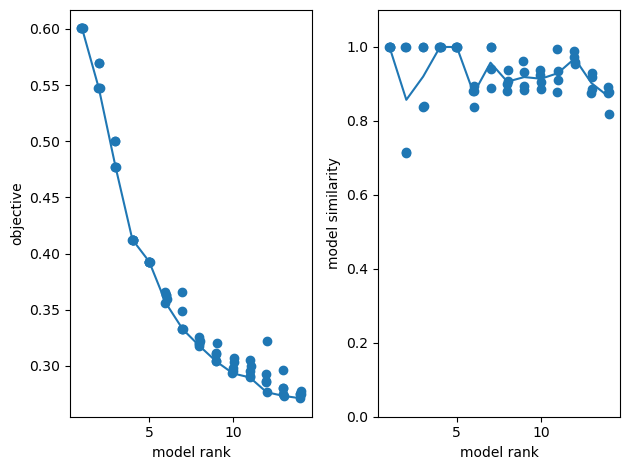

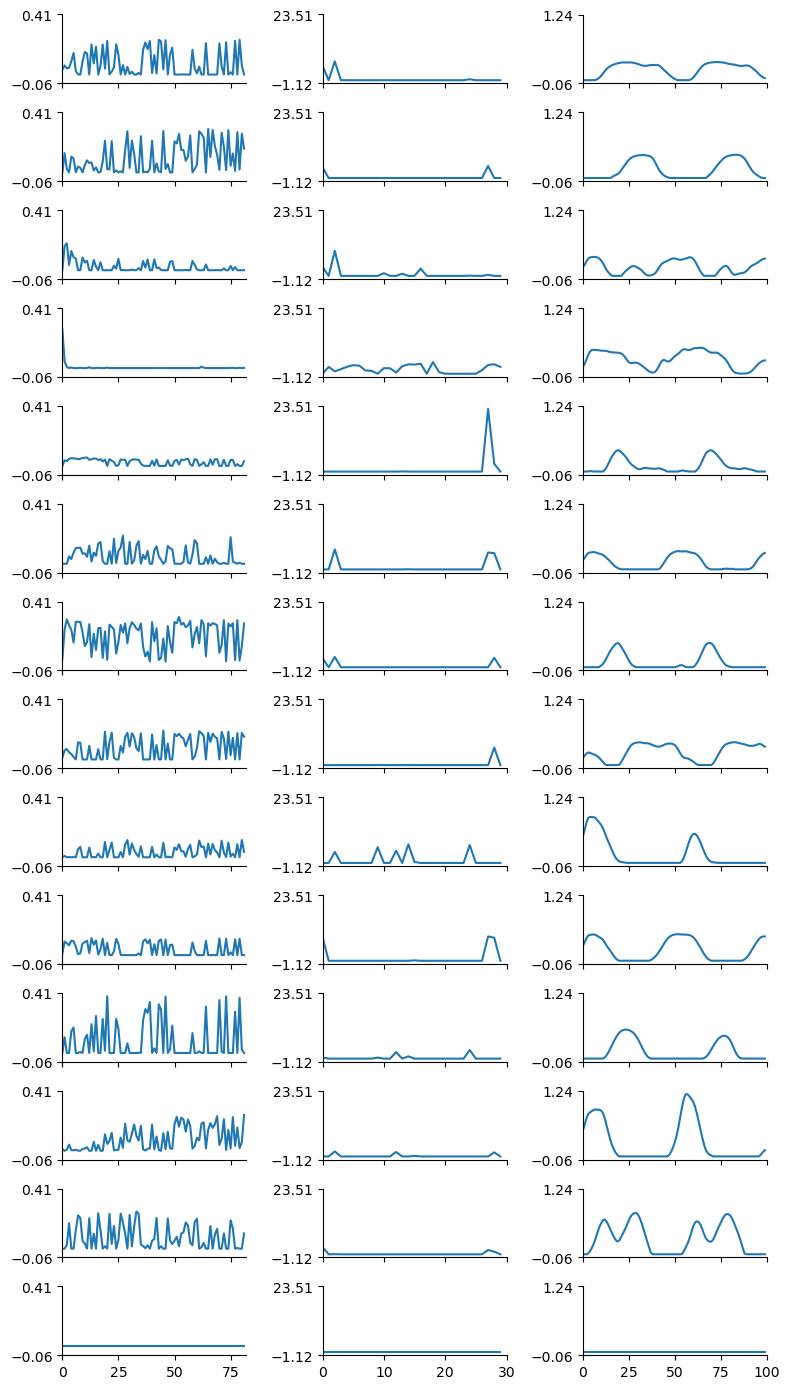

In [49]:
# Optimum num of components using reconstruction error
num_components = 15

# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(spikes_tensor, ranks=range(1, num_components), replicates=5)  # range(1,32)

fig, axes = plt.subplots(1, 2)
# plot reconstruction error as a function of num components.
tt.plot_objective(ensemble, ax=axes[0])
# plot model similarity as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])
fig.tight_layout()

# Plot the low-d factors
replicate = 0
tt.plot_factors(ensemble.factors(num_components - 1)[replicate])

plt.show()

In [50]:
rank = 6

during_training_model = fit_shifted_cp(
    spikes_tensor,
    rank=rank,
    boundary="wrap",
    # n_restarts=N_RESTARTS,
    n_restarts=10,
    max_shift_axis0=MAX_SHIFT,
    max_shift_axis1=None,
    max_iter=100,
    u_nonneg=True,
    v_nonneg=True,
)

/var/folders/_y/8xzgj7nj7v735qcwth8br3nh0000gp/T/ipykernel_64405/3906637862.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_ranks)


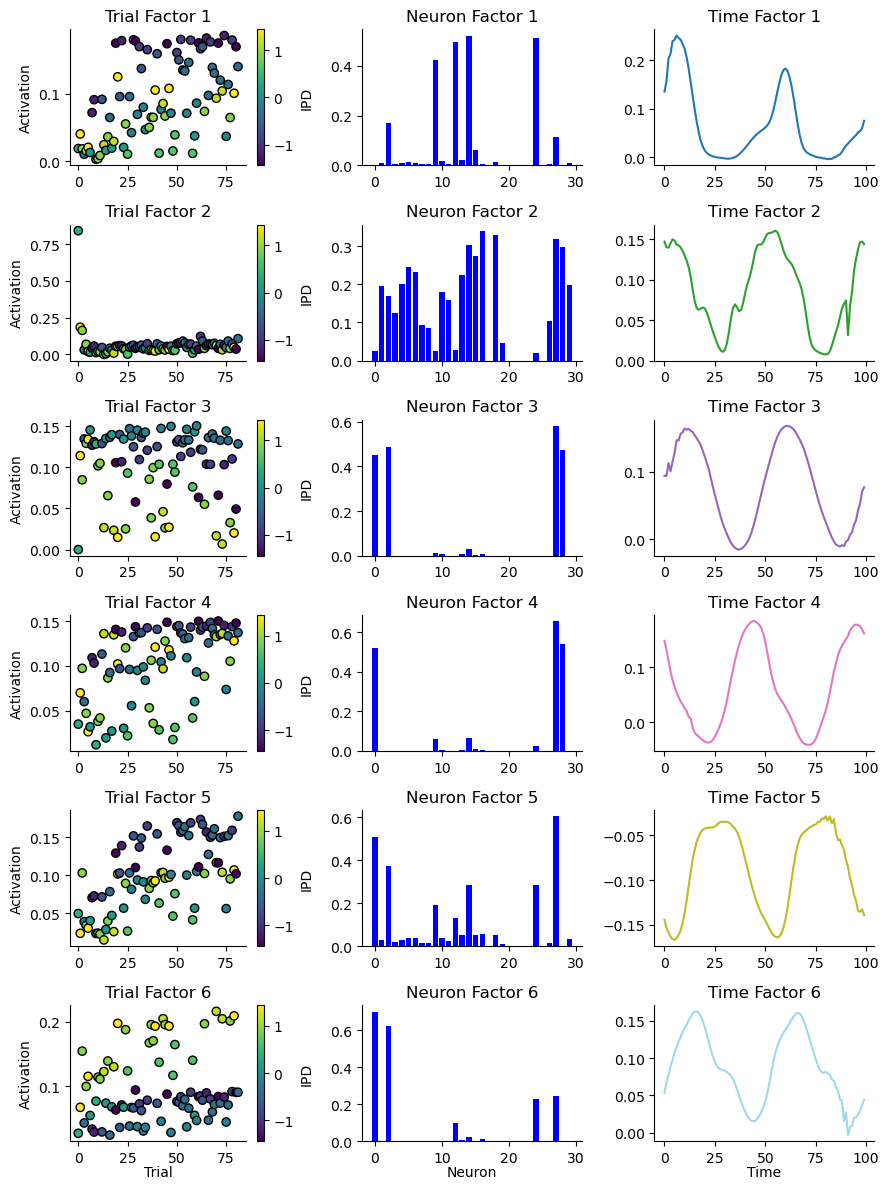

In [51]:
fig = plot_result_with_ipd_coloring(
    during_training_model, recorded_ipds, vertical_layout=True
)
plt.show()

/var/folders/_y/8xzgj7nj7v735qcwth8br3nh0000gp/T/ipykernel_64405/3906637862.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_ranks)


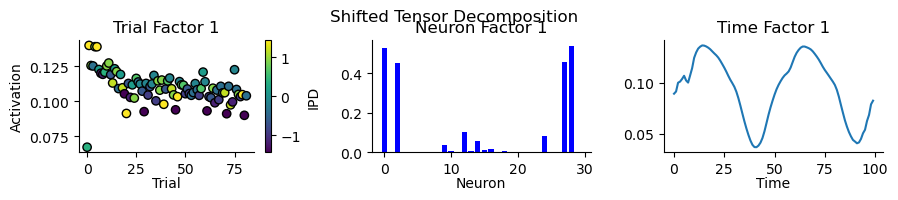

In [52]:
# Rank 1 model
during_training_model1 = fit_shifted_cp(
    spikes_tensor,
    rank=1,
    boundary="wrap",
    # n_restarts=N_RESTARTS,
    n_restarts=10,
    max_shift_axis0=MAX_SHIFT,
    max_shift_axis1=None,
    max_iter=100,
    u_nonneg=True,
    v_nonneg=True,
)

fig = plot_result_with_ipd_coloring(
    during_training_model1, recorded_ipds, vertical_layout=True
)
fig.suptitle("Shifted Tensor Decomposition")
plt.show()

### Evaluation post-training:

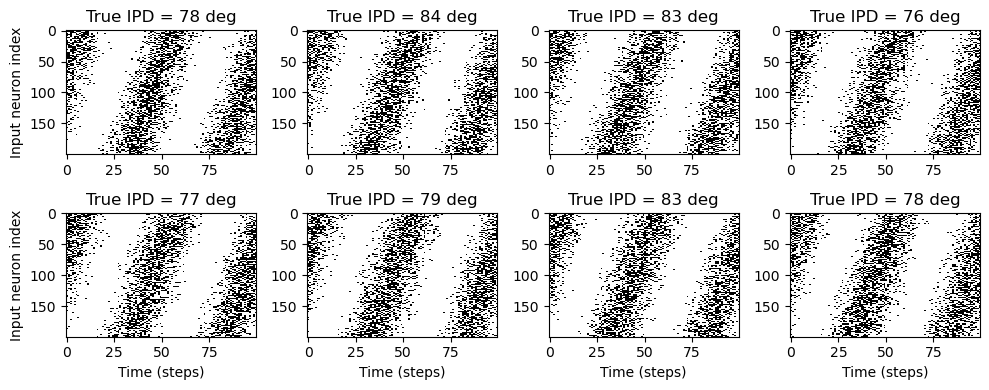

In [53]:
# Single IPD dataset
def non_random_ipd_input_signal(num_samples, bin=1, tensor=True):
    # ipd = (
    #     np.random.rand(num_samples) * np.pi - np.pi / 2
    # )  # uniformly random in (-pi/2, pi/2)
    # generate a set of ipds that are all the same
    # ipd = np.repeat(ipd, num_samples)
    # generate ipds that fall within the class range
    ipd = continuise(bin)
    ipd = np.repeat(ipd, num_samples)
    # add noise to ipds of 7.5 degrees
    ipd = ipd + np.random.uniform(-np.pi / 24, np.pi / 24, size=ipd.shape)

    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes


# Plot a few just to show how it looks
# bins range from 0 - 11
bin = 5
ipd, spikes = non_random_ipd_input_signal(8, bin=11)  # 6 is 0+15 degrees
spikes_plot = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        spikes_plot[i, :, :].T,
        aspect="auto",
        interpolation="nearest",
        cmap=plt.cm.gray_r,
    )
    plt.title(f"True IPD = {int(ipd[i]*180/np.pi)} deg")
    if i >= 4:
        plt.xlabel("Time (steps)")
    if i % 4 == 0:
        plt.ylabel("Input neuron index")
plt.tight_layout()

In [54]:
def evaluate_full_ipd_range(ipds, spikes, model):
    """
    This function evaluates a model across the full range of IPD values and collects the output spikes
    and estimated IPDs.
    """
    spike_data = []
    ipd_data = []
    estimated_ipd_data = []

    # Generate data in batches and evaluate
    for x_local, y_local in data_generator(discretise(ipds), spikes, random=False):
        # Run the model to get output spikes and membrane potentials
        output = model(x_local)
        output_spikes, output_vrec = output

        # Compute the estimated IPDs from the output membrane potentials
        _, estimated_ipds = torch.max(
            output_vrec, dim=1
        )  # Ensure you specify the dimension if needed

        # get the estimated ipds as a list of categories
        estimated_ipds = estimated_ipds.cpu().detach().numpy()
        # convert from [4096, 12] to [4096]
        estimated_ipds = np.argmax(estimated_ipds, axis=1)

        # Collect output spikes, true IPD values, and estimated IPD values
        spike_data.append(output_spikes.detach().cpu().numpy())
        ipd_data.append(y_local.detach().cpu().numpy())
        estimated_ipd_data.append(estimated_ipds)

    # Convert list to tensors
    spikes_tensor = torch.tensor(np.concatenate(spike_data), dtype=torch.float32)
    ipd_tensor = torch.tensor(np.concatenate(ipd_data), dtype=torch.float32)
    estimated_ipd_tensor = torch.tensor(
        np.concatenate(estimated_ipd_data), dtype=torch.int64
    )

    return spikes_tensor, ipd_tensor, estimated_ipd_tensor


print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
snn_model = lambda x: snn(x, W1, W2)

Chance accuracy level: 8.3%


In [55]:
# Single IPD
# ipd, spikes = non_random_ipd_input_signal(num_samples, bin=bin)
# Normal random IPD
# ipd, spikes = random_ipd_input_signal(num_samples)
# Ordered IPDs
ipd, spikes = random_step_ipd_input_signal(num_samples)

print("spikes shape: ", spikes.shape)
output_spikes_test, output_ipds_test, output_est_ipds = evaluate_full_ipd_range(
    ipd, spikes, snn_model
)

print("Output spikes test shape:", output_spikes_test.shape)
print("Output IPDs test shape:", output_ipds_test.shape)
print("Output estimated IPDs shape:", output_est_ipds.shape)

output_ipds_test_pca = output_ipds_test.detach().cpu().numpy().astype(np.float64)
output_est_ipds_pca = output_est_ipds.detach().cpu().numpy().astype(np.float64)

# create a vecctor with 0 and 1 for correct and incorrect predictions
correct_predictions = (output_ipds_test_pca == output_est_ipds_pca).astype(int)
incorrect_predictions = (output_ipds_test_pca != output_est_ipds_pca).astype(int)
print("Number of correct predictions:", np.sum(correct_predictions))
print("Number of incorrect predictions:", np.sum(incorrect_predictions))

spikes shape:  torch.Size([4096, 100, 200])
Output spikes test shape: torch.Size([4096, 100, 30])
Output IPDs test shape: torch.Size([4096])
Output estimated IPDs shape: torch.Size([4096])
Number of correct predictions: 884
Number of incorrect predictions: 3212


In [56]:
def transform_eval_spikes(recorded_spikes, sigma=2.0):
    # Convert to num samples, neurons, time
    reshaped_spikes = recorded_spikes.permute(0, 2, 1).cpu().numpy().astype(np.float64)

    # Apply Gaussian smoothing along the time axis for each neuron
    smoothed_spikes = np.zeros_like(reshaped_spikes)
    for i in range(reshaped_spikes.shape[0]):
        for j in range(reshaped_spikes.shape[1]):
            smoothed_spikes[i, j, :] = gaussian_filter1d(
                reshaped_spikes[i, j, :], sigma=sigma
            )

    return smoothed_spikes

In [57]:
output_spikes_test = transform_eval_spikes(output_spikes_test)

output_ipds_test = (
    output_ipds_test.view(-1).detach().cpu().numpy().astype(np.float64).flatten()
)
print("Output spikes test shape:", output_spikes_test.shape)
print("Output IPDs test shape:", output_ipds_test.shape)

# Reduce the size of the spikes_tensor, recorded_ipds and recorded_estimated_ipds by sampling every 10th sample
divide_by = 10
output_spikes_test = output_spikes_test[::divide_by]
output_ipds_test = output_ipds_test[::divide_by]

print("Output spikes test shape:", output_spikes_test.shape)
print("Output IPDs test shape:", output_ipds_test.shape)

Output spikes test shape: (4096, 30, 100)
Output IPDs test shape: (4096,)
Output spikes test shape: (410, 30, 100)
Output IPDs test shape: (410,)


Fitting rank-1 models:   0%|          | 0/5 [00:00<?, ?it/s]

Rank-1 models:  min obj, 0.62;  max obj, 0.62;  time to fit, 0.1s


Rank-2 models:  min obj, 0.57;  max obj, 0.62;  time to fit, 0.6s


Rank-3 models:  min obj, 0.50;  max obj, 0.52;  time to fit, 0.5s


Rank-4 models:  min obj, 0.42;  max obj, 0.50;  time to fit, 0.6s


Rank-5 models:  min obj, 0.38;  max obj, 0.50;  time to fit, 0.9s


Rank-6 models:  min obj, 0.35;  max obj, 0.42;  time to fit, 1.5s


Rank-7 models:  min obj, 0.33;  max obj, 0.35;  time to fit, 1.2s


Rank-8 models:  min obj, 0.33;  max obj, 0.36;  time to fit, 1.5s


Rank-9 models:  min obj, 0.31;  max obj, 0.33;  time to fit, 2.2s


Rank-10 models:  min obj, 0.29;  max obj, 0.32;  time to fit, 2.7s


Rank-11 models:  min obj, 0.29;  max obj, 0.35;  time to fit, 2.6s


Rank-12 models:  min obj, 0.27;  max obj, 0.31;  time to fit, 2.6s


Rank-13 models:  min obj, 0.29;  max obj, 0.33;  time to fit, 3.4s


Rank-14 models:  min obj, 0.27;  max obj, 0.29;  time to fit, 3.3s


Rank-15 models:  min obj, 0.26;  max obj, 0.32;  time to fit, 3.4s


Rank-16 models:  min obj, 0.26;  max obj, 0.29;  time to fit, 6.4s


Rank-17 models:  min obj, 0.26;  max obj, 0.29;  time to fit, 10.5s


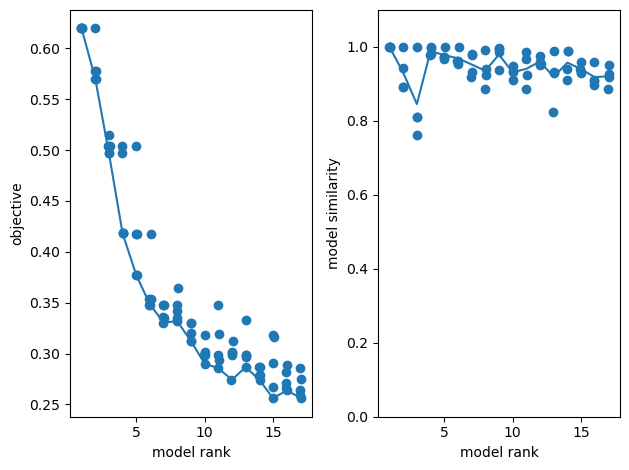

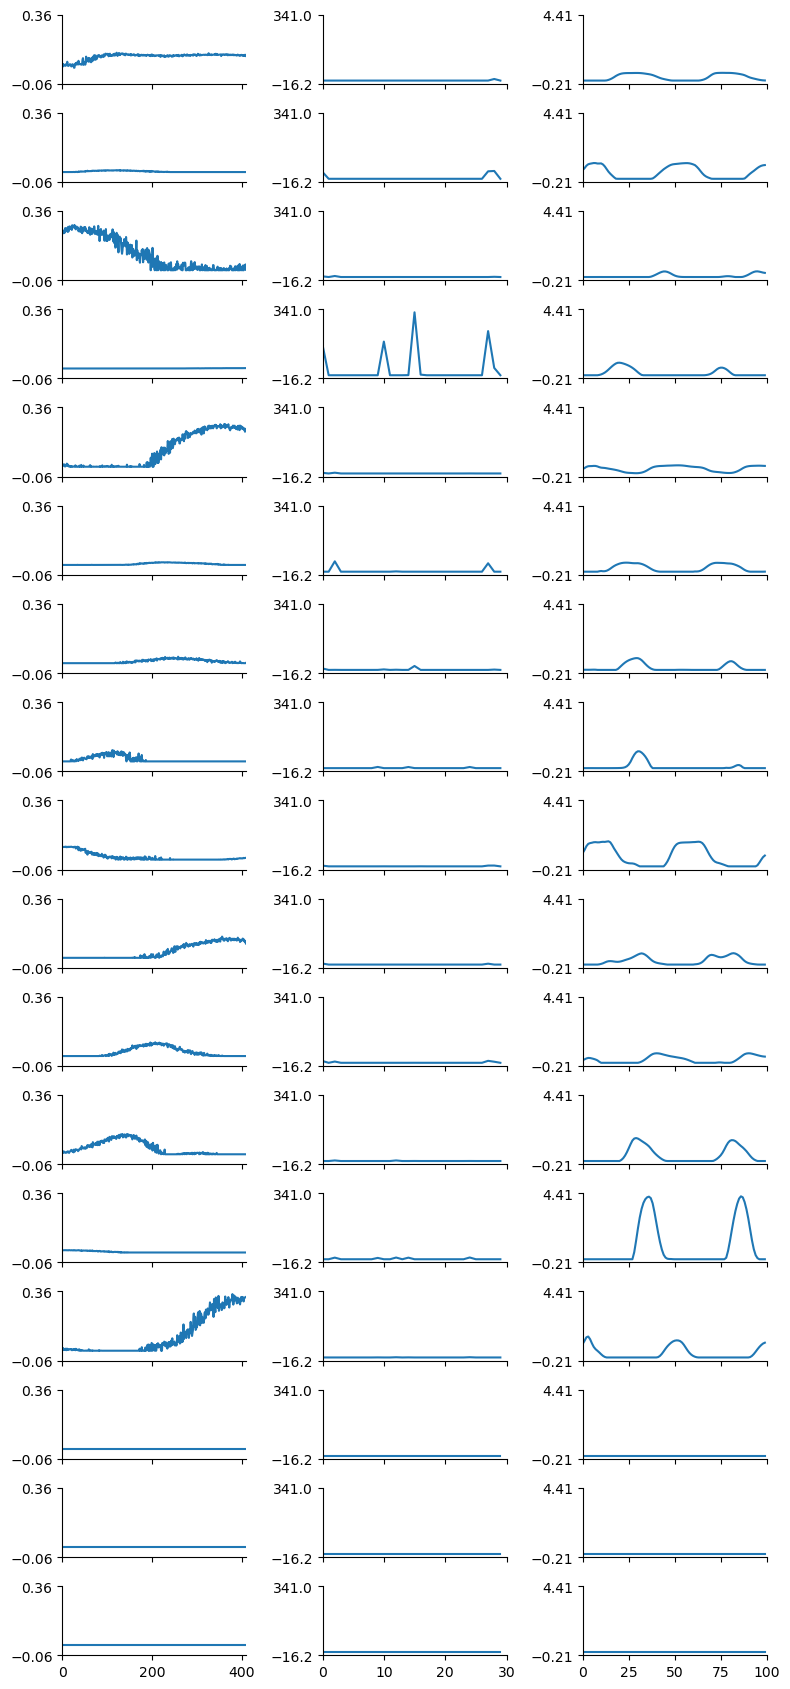

In [58]:
# test up to 18 components
num_components = 18

# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(
    output_spikes_test, ranks=range(1, num_components), replicates=5
)  # range(1,32)
# list of numbers from 1 to 40 in steps of 5 range(7, 10, 2)

fig, axes = plt.subplots(1, 2)
# plot reconstruction error as a function of num components.
tt.plot_objective(ensemble, ax=axes[0])
# plot model similarity as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])
fig.tight_layout()

# Plot the low-d factors =
replicate = 0
tt.plot_factors(
    ensemble.factors(num_components - 1)[replicate]
)  # plot the low-d factors

plt.show()

/var/folders/_y/8xzgj7nj7v735qcwth8br3nh0000gp/T/ipykernel_64405/3906637862.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_ranks)


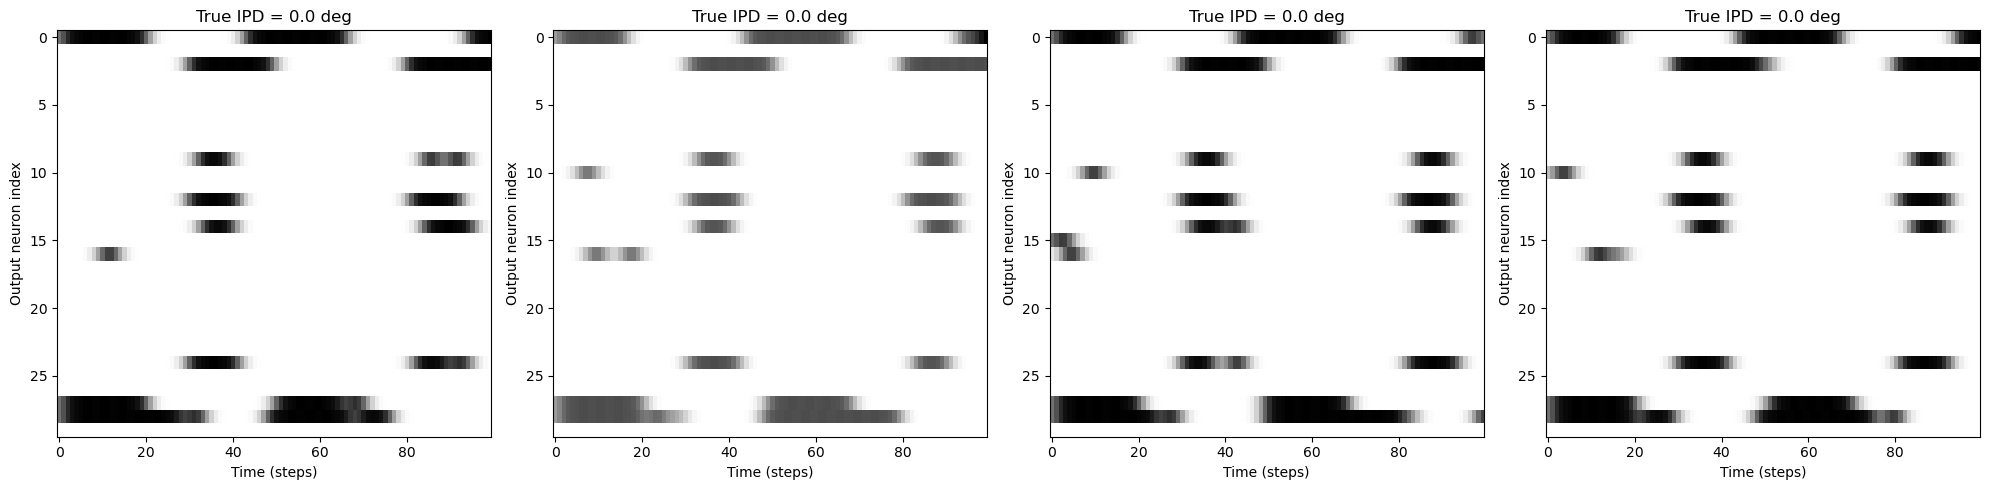

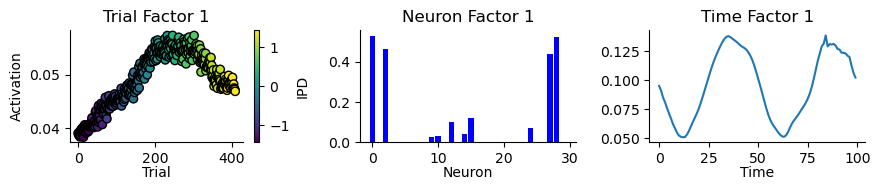

In [59]:
eval_testing_model = fit_shifted_cp(
    output_spikes_test,
    rank=1,
    boundary="wrap",
    n_restarts=N_RESTARTS,
    max_shift_axis0=MAX_SHIFT,
    max_shift_axis1=None,
    max_iter=100,
    u_nonneg=False,
    v_nonneg=True,
)

# Plot a few raster plots of output_spikes_test ([4096, 100, 30])
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(
        output_spikes_test[i, :, :],
        aspect="auto",
        interpolation="nearest",
        cmap=plt.cm.gray_r,
    )
    axs[i].set_title(f"True IPD = {output_ipds_test[i]} deg")
    axs[i].set_xlabel("Time (steps)")
    axs[i].set_ylabel("Output neuron index")
plt.tight_layout()

# Example usage assuming model is defined and appropriate
fig = plot_result_with_ipd_coloring(
    eval_testing_model, output_ipds_test, vertical_layout=True
)
# fig.suptitle("Shifted Tensor Decomposition")
plt.show()

/var/folders/_y/8xzgj7nj7v735qcwth8br3nh0000gp/T/ipykernel_64405/3906637862.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_ranks)


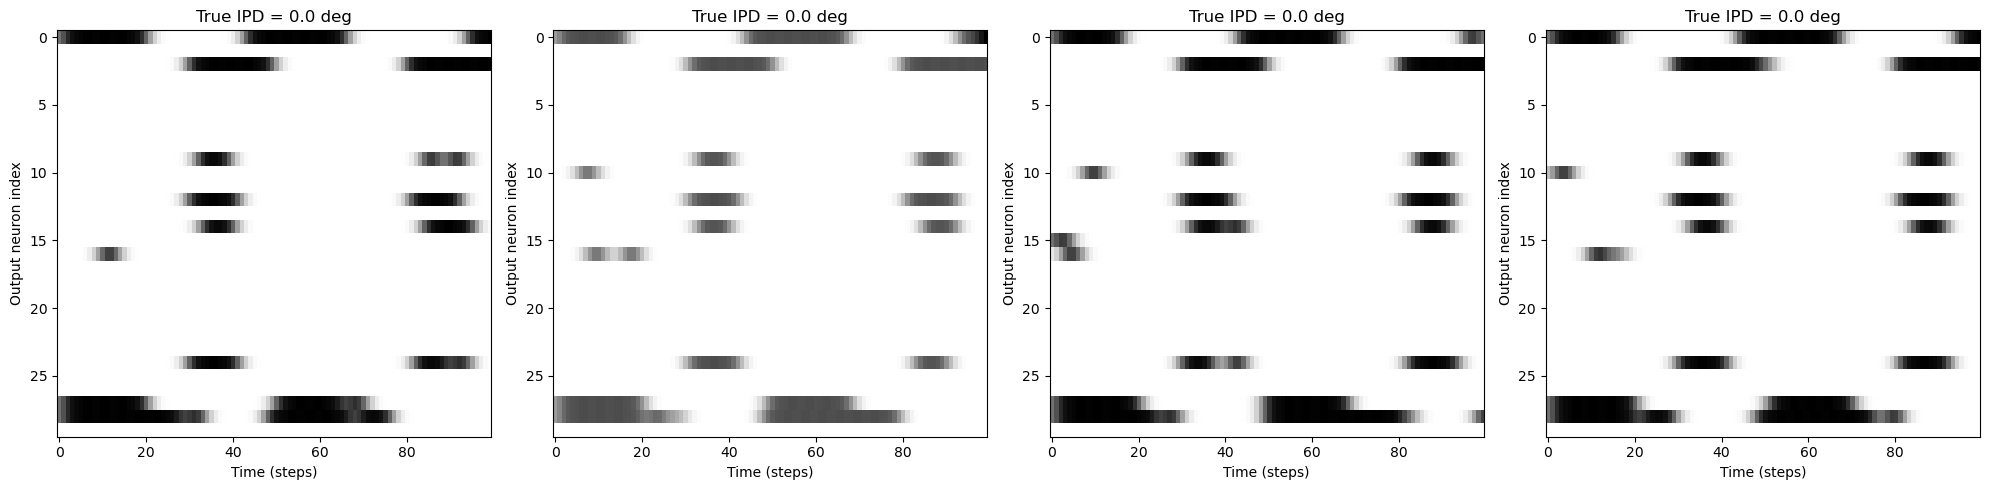

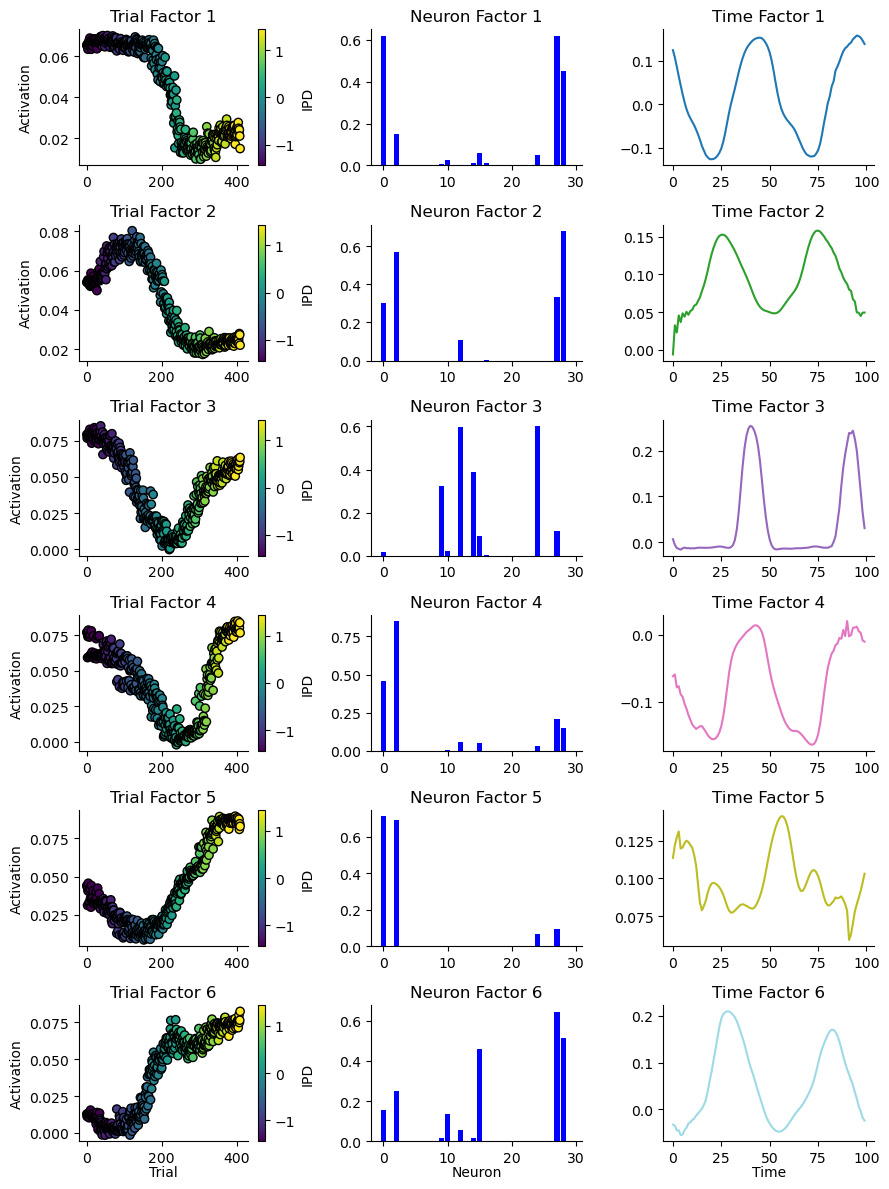

In [60]:
eval_testing_model = fit_shifted_cp(
    output_spikes_test,
    rank=rank,
    boundary="wrap",
    n_restarts=N_RESTARTS,
    max_shift_axis0=MAX_SHIFT,
    max_shift_axis1=None,
    max_iter=100,
    u_nonneg=False,
    v_nonneg=True,
)

# Plot a few raster plots of output_spikes_test ([4096, 100, 30])
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(
        output_spikes_test[i, :, :],
        aspect="auto",
        interpolation="nearest",
        cmap=plt.cm.gray_r,
    )
    axs[i].set_title(f"True IPD = {output_ipds_test[i]} deg")
    axs[i].set_xlabel("Time (steps)")
    axs[i].set_ylabel("Output neuron index")
plt.tight_layout()

# Example usage assuming model is defined and appropriate
fig = plot_result_with_ipd_coloring(
    eval_testing_model, output_ipds_test, vertical_layout=True
)
# fig.suptitle("Shifted Tensor Decomposition")
plt.show()

In [ ]:
import concurrent.futures
import pandas as pd


def train_and_evaluate(ipds, spikes, nb_epochs, lr, num_classes, rank, batch_function):
    W1, W2, recorded_spikes, recorded_input_ipds, recorded_estimated_ipds = (
        train_network(ipds, spikes, nb_epochs, lr, num_classes)
    )
    spikes_tensor = transform_spikes(recorded_spikes)
    spikes_tensor = spikes_tensor[::500]
    during_training_model = fit_shifted_cp(
        spikes_tensor,
        rank=rank,
        boundary="wrap",
        n_restarts=10,
        max_shift_axis0=MAX_SHIFT,
        max_iter=100,
        u_nonneg=True,
        v_nonneg=True,
    )
    output_spikes_test, output_ipds_test, output_est_ipds = evaluate_full_ipd_range(
        ipds, spikes, lambda x: snn(x, W1, W2)
    )
    output_spikes_test = transform_eval_spikes(output_spikes_test)[::10]
    eval_testing_model = fit_shifted_cp(
        output_spikes_test,
        rank=rank,
        boundary="wrap",
        n_restarts=10,
        max_shift_axis0=MAX_SHIFT,
        max_iter=100,
        u_nonneg=False,
        v_nonneg=True,
    )
    train_accuracy = analyse(ipds, spikes, "Train", lambda x: snn(x, W1, W2)[-1])
    ipds_test, spikes_test = random_ipd_input_signal(num_samples)
    test_accuracy = analyse(
        ipds_test, spikes_test, "Test", lambda x: snn(x, W1, W2)[-1]
    )

    return (during_training_model, eval_testing_model, train_accuracy, test_accuracy)


def run_multiple_experiments(
    num_trials, ipds, spikes, nb_epochs, lr, num_classes, rank, batch_function
):
    results = []
    accuracies = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        futures = [
            executor.submit(
                train_and_evaluate,
                ipds,
                spikes,
                nb_epochs,
                lr,
                num_classes,
                rank,
                batch_function,
            )
            for _ in range(num_trials)
        ]
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                results.append(result[:2])  # Store models
                accuracies.append(
                    {"Train Accuracy": result[2], "Test Accuracy": result[3]}
                )
            except Exception as e:
                print(f"An error occurred: {e}")
                # Optionally handle the failed case or retry

    df_accuracies = pd.DataFrame(accuracies)
    return results, df_accuracies


nb_epochs = 10
lr = 0.01
rank = 1
num_samples = 1000
ipds, spikes = random_ipd_input_signal(num_samples)
results, accuracies = run_multiple_experiments(
    50, ipds, spikes, nb_epochs, lr, num_classes, rank, data_generator
)

print(accuracies)

In [62]:
# results[0][0].factors[0].shape  # trial factors
# # results[0][0].factors[1].shape # neuron factors
# # results[0][0].factors[2].shape # time factors

# models = [result[0] for result in results]

In [63]:
# Extracting only the during training models for analysis
models = [result[0] for result in results]

if models:
    print("Shape of trial factors:", models[0].factors[0].shape)  # trial factors
    print("Shape of neuron factors:", models[0].factors[1].shape)  # neuron factors
    print("Shape of time factors:", models[0].factors[2].shape)  # time factors

Shape of trial factors: (1, 20)
Shape of neuron factors: (1, 30)
Shape of time factors: (1, 100)


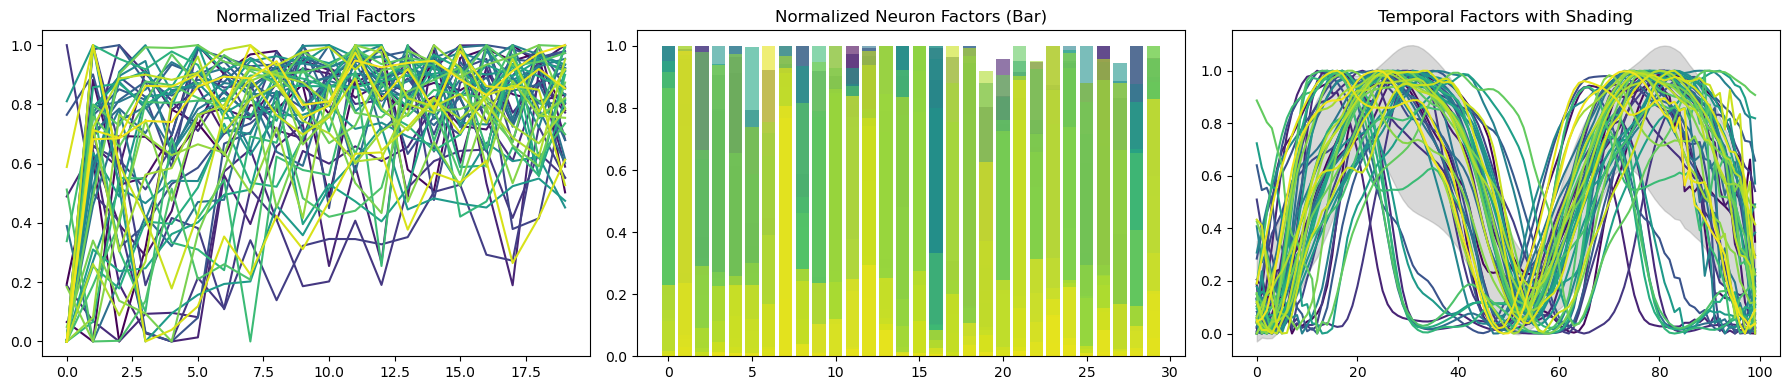

In [64]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def plot_factors(models, normalize_temporal=False):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    temporal_data_all = []

    for i, model in enumerate(models):
        color = plt.cm.viridis(i / len(models))

        # Normalize trial data
        trial_data = normalize_data(model.factors[0][0, :])
        axes[0].plot(trial_data, label=f"Model {i+1}", color=color)

        # Normalize neuron data
        neuron_data = normalize_data(model.factors[1][0, :])
        axes[1].bar(
            np.arange(len(neuron_data)),
            neuron_data,
            label=f"Model {i+1}",
            color=color,
            alpha=0.6,
        )

        # temporal data
        temporal_data = model.factors[2][0, :]
        if normalize_temporal:
            temporal_data = normalize_data(temporal_data)
        axes[2].plot(temporal_data, label=f"Model {i+1}", color=color)

        # shading
        temporal_data_all.append(temporal_data)

    temporal_mean = np.mean(temporal_data_all, axis=0)
    temporal_std = np.std(temporal_data_all, axis=0)

    axes[2].fill_between(
        range(len(temporal_mean)),
        temporal_mean - temporal_std,
        temporal_mean + temporal_std,
        color="gray",
        alpha=0.3,
    )

    axes[0].set_title("Normalized Trial Factors")
    axes[1].set_title("Normalized Neuron Factors (Bar)")
    axes[2].set_title("Temporal Factors with Shading")

    # for ax in axes:
    #     ax.legend(loc="upper right")
    # ax.grid(True)

    plt.tight_layout()
    plt.show()


plot_factors(models, normalize_temporal=True)

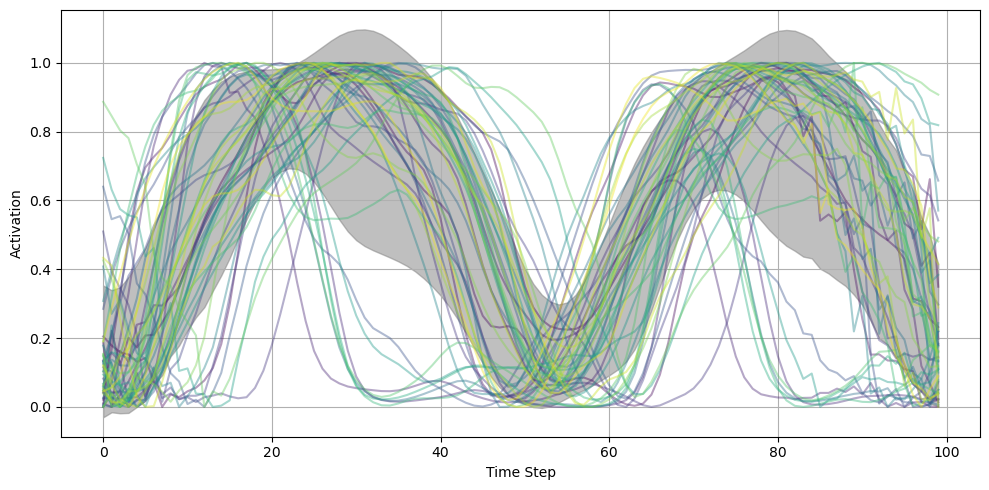

In [65]:
def plot_temporal_factors(models, normalize_temporal=False):
    fig, ax = plt.subplots(figsize=(10, 5))

    temporal_data_all = []

    for i, model in enumerate(models):
        color = plt.cm.viridis(i / len(models))

        temporal_data = model.factors[2][0, :]
        if normalize_temporal:
            temporal_data = normalize_data(temporal_data)
        ax.plot(temporal_data, label=f"Model {i+1}", color=color, alpha=0.4)

        temporal_data_all.append(temporal_data)

    temporal_mean = np.mean(temporal_data_all, axis=0)
    temporal_std = np.std(temporal_data_all, axis=0)

    ax.fill_between(
        range(len(temporal_mean)),
        temporal_mean - temporal_std,
        temporal_mean + temporal_std,
        color="gray",
        alpha=0.5,
    )

    # ax.set_title("Temporal Factors with Shading")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Activation")

    # if len(models) > 1:
    #     ax.legend(loc="upper right")
    ax.grid(True)

    plt.tight_layout()
    plt.show()


plot_temporal_factors(models, normalize_temporal=True)

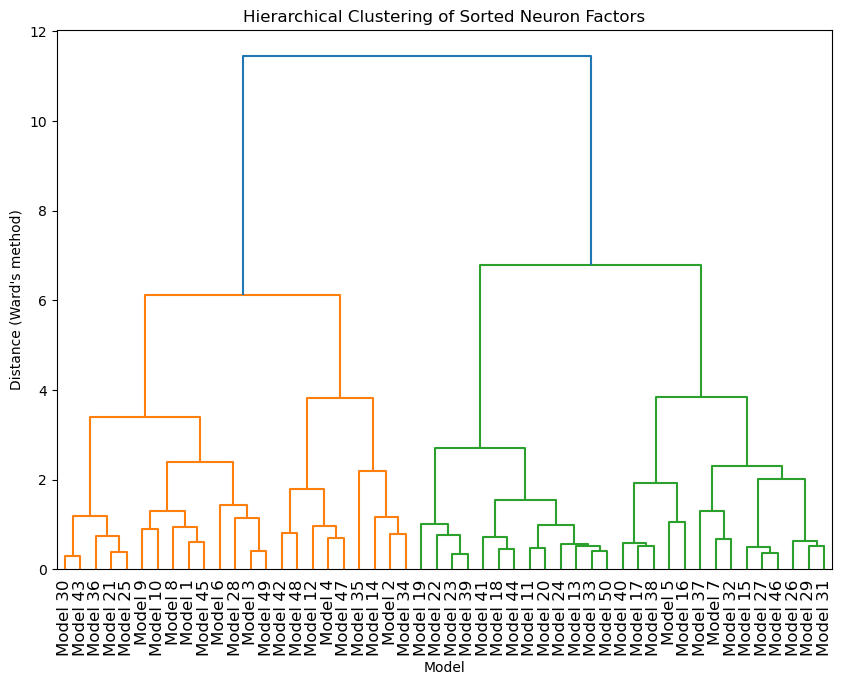

In [66]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


def normalize_data(data):
    """Normalize the data to have zero mean and unit variance."""
    scaler = StandardScaler()
    data = data.reshape(-1, 1)  # Reshape data to 2D if it's 1D
    normalized_data = scaler.fit_transform(data)
    return normalized_data.flatten()


sorted_normalized_factors = []
for model in models:
    normalized_factors = normalize_data(model.factors[1][0, :])
    indices = np.argsort(normalized_factors)[::-1]  # Sort by descending order
    sorted_factors = normalized_factors[indices]
    sorted_normalized_factors.append(sorted_factors)

neuron_factors = np.vstack(sorted_normalized_factors)
Z = linkage(neuron_factors, method="ward")

# Determine the clusters at a certain distance threshold
cluster_labels = fcluster(Z, t=5, criterion="distance")
# Count number of models per cluster
cluster_count = np.bincount(cluster_labels)
# Find the most prevalent cluster
most_prevalent_cluster = np.argmax(cluster_count[1:]) + 1

# Filter models that belong to the most prevalent cluster
cluster_models = [
    models[i] for i in range(len(models)) if cluster_labels[i] == most_prevalent_cluster
]

plt.figure(figsize=(10, 7))
dendrogram(
    Z,
    labels=[f"Model {i+1}" for i in range(len(models))],
    leaf_rotation=90,
    leaf_font_size=12,
)
plt.title("Hierarchical Clustering of Sorted Neuron Factors")
plt.xlabel("Model")
plt.ylabel("Distance (Ward's method)")
plt.show()

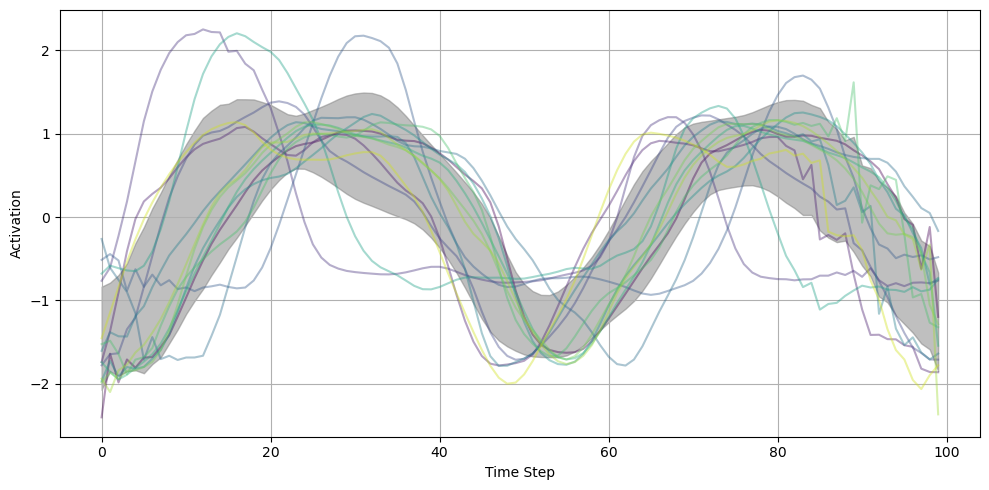

In [67]:
# Plot temporal factors for models in the most prevalent cluster
plot_temporal_factors(cluster_models, normalize_temporal=True)

In [68]:
def count_highly_active_neurons(neuron_factors, threshold=0.5):
    """Count the number of neurons that are above the activation threshold."""
    return (neuron_factors > threshold).sum(axis=1)


# Normalize and sort the neuron factors
sorted_normalized_neurons = []
for model in models:
    normalized_neurons = normalize_data(model.factors[1][0, :])
    sorted_neurons = np.sort(normalized_neurons)[::-1]
    sorted_normalized_neurons.append(sorted_neurons)

# Stack and cluster
neuron_factors = np.vstack(sorted_normalized_neurons)
Z = linkage(neuron_factors, method="ward")
cluster_labels = fcluster(Z, t=5, criterion="distance")

# Analyze clusters
cluster_stats = {}
for cluster_label in np.unique(cluster_labels):
    indices = np.where(cluster_labels == cluster_label)[0]
    cluster_neurons = neuron_factors[indices]
    active_counts = count_highly_active_neurons(cluster_neurons)
    train_accuracies = [accuracies.iloc[i]["Train Accuracy"] for i in indices]
    test_accuracies = [accuracies.iloc[i]["Test Accuracy"] for i in indices]
    cluster_stats[cluster_label] = {
        "models": indices,
        "active_neuron_counts": active_counts,
        "average_active_neurons": np.mean(active_counts),
        "std_dev_active_neurons": np.std(active_counts),
        "average_train_accuracy": np.mean(train_accuracies),
        "average_test_accuracy": np.mean(test_accuracies),
    }

# Output the results for analysis
for label, stats in cluster_stats.items():
    print(f"Cluster {label}:")
    print(f"  Number of models: {len(stats['models'])}")
    print(f"  Average highly active neurons: {stats['average_active_neurons']:.2f}")
    print(f"  Standard deviation: {stats['std_dev_active_neurons']:.2f}")
    print(f"  Average Train Accuracy: {stats['average_train_accuracy']:.2f}%")
    print(f"  Average Test Accuracy: {stats['average_test_accuracy']:.2f}%")
    print(f"  Active counts per model: {stats['active_neuron_counts']}")

Cluster 1:
  Number of models: 14
  Average highly active neurons: 4.43
  Standard deviation: 0.98
  Average Train Accuracy: 71.13%
  Average Test Accuracy: 46.45%
  Active counts per model: [3 4 6 6 6 4 4 5 5 4 4 4 3 4]
Cluster 2:
  Number of models: 9
  Average highly active neurons: 4.11
  Standard deviation: 1.45
  Average Train Accuracy: 69.51%
  Average Test Accuracy: 39.81%
  Active counts per model: [4 2 3 4 4 7 6 4 3]
Cluster 3:
  Number of models: 13
  Average highly active neurons: 5.54
  Standard deviation: 0.63
  Average Train Accuracy: 70.44%
  Average Test Accuracy: 44.98%
  Active counts per model: [5 5 5 6 5 6 6 6 5 6 7 5 5]
Cluster 4:
  Number of models: 14
  Average highly active neurons: 8.36
  Standard deviation: 1.11
  Average Train Accuracy: 69.86%
  Average Test Accuracy: 46.29%
  Active counts per model: [11  8  8 10  9  7  8  7  7  8  8  9  9  8]
